<a href="https://colab.research.google.com/github/TishaJeswani/codsoft_task3-level1-/blob/master/User_based_collaborative_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#E-commerce Product recommendation System

##Importing libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics import mean_squared_error

## Importing Dataset

In [ ]:
#Import the data set
df = pd.read_csv('/content/ratings_Electronics.csv', header=None) #There are no headers in the data file

df.columns = ['user_id', 'prod_id', 'rating', 'timestamp'] #Adding column names

df = df.drop('timestamp', axis=1) #Dropping timestamp

df_copy = df.copy(deep=True) #Copying the data to another dataframe

## EDA - Exploratory Data Analysis

check for -
- shape
- datatype
- missing values


finally get the summary and check
- rating distribution.
- number of users and products.
- Users with highest no of ratings.

### Shape

In [ ]:
rows, columns = df.shape
print("No of rows = ", rows)
print("No of columns = ", columns)

No of rows =  1184492
No of columns =  3


### Datatypes

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1184492 entries, 0 to 1184491
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   user_id  1184492 non-null  object 
 1   prod_id  1184491 non-null  object 
 2   rating   1184491 non-null  float64
dtypes: float64(1), object(2)
memory usage: 27.1+ MB


### Missing value analysis

In [ ]:
# Find number of missing values in each column
df.isna().sum()

,0
user_id,0
prod_id,1
rating,1


### Summary

In [ ]:
# Summary statistics of 'rating' variable
df['rating'].describe()

,rating
count,1.184491e+06
mean,3.980067e+00
std,1.396297e+00
min,1.000000e+00
25%,3.000000e+00
50%,5.000000e+00
75%,5.000000e+00
max,5.000000e+00


### Rating distribution

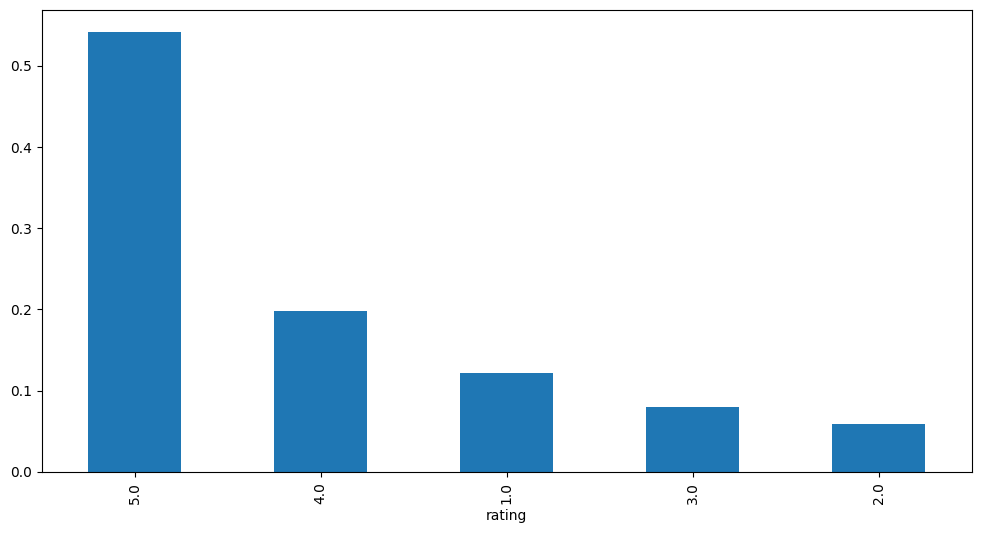

In [ ]:
#Create the plot and provide observations

plt.figure(figsize = (12,6))
df['rating'].value_counts(1).plot(kind='bar')
plt.show()

The distribution is skewed to the right. Over 50% of the ratings are 5, followed by a little below 20% with 4 star ratings. And the percentages of ratings keep going down until below 10% of the ratings are 2 stars.

### No of unique users and items

In [ ]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df['user_id'].nunique())
print('Number of unique ITEMS in Raw data = ', df['prod_id'].nunique())

Number of unique USERS in Raw data =  874093
Number of unique ITEMS in Raw data =  69778


### Users with most no of rating

In [ ]:
# Top 10 users based on rating
most_rated = df.groupby('user_id').size().sort_values(ascending=False)[:10]
most_rated

user_id
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
dtype: int64

## Pre-Processing

Let's take a subset of the dataset (by only keeping the users who have given 50 or more ratings) to make the dataset less sparse and easy to work with.

In [ ]:
counts = df['user_id'].value_counts()
df_final = df[df['user_id'].isin(counts[counts >= 50].index)]

In [ ]:
print('The number of observations in the final data =', len(df_final))
print('Number of unique USERS in the final data = ', df_final['user_id'].nunique())
print('Number of unique PRODUCTS in the final data = ', df_final['prod_id'].nunique())

The number of observations in the final data = 4052
Number of unique USERS in the final data =  46
Number of unique PRODUCTS in the final data =  3379


- The dataframe **df_final has users who have rated 50 or more items**
- **We will use df_final to build recommendation systems**

### Checking the density of the rating matrix

In [ ]:
#Creating the interaction matrix of products and users based on ratings and replacing NaN value with 0
final_ratings_matrix = df_final.pivot(index = 'user_id', columns ='prod_id', values = 'rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

#Finding the number of non-zero entries in the interaction matrix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)

#Finding the possible number of ratings as per the number of users and products
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)

#Density of ratings
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

final_ratings_matrix.head()

Shape of final_ratings_matrix:  (46, 3379)
given_num_of_ratings =  4052
possible_num_of_ratings =  155434
density: 2.61%


prod_id,1400532655,1400599997,9043413585,9981719005,998376234X,B000000O48,B000001OL6,B000001OMI,B000001OMN,B00000DM9W,...,B000MTRWVY,B000MUXJCO,B000MV7WQW,B000MVEC10,B000MVGBFU,B000MVJ1M0,B000MW3YE0,B000MWNJPE,B000MX1QXA,B000MX48VM
user_id,,,,,,,,,,,,,,,,,,,,,
A11D1KHM7DVOQK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A11KZ906QD08C5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A12DLJESJKM1OQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1435P5AMCPB3X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A149RNR5RH19YY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Collaborative Filtering based Recommendation System

## User based collaborative filtering

In [ ]:
final_ratings_matrix.head()

prod_id,1400532655,1400599997,9043413585,9981719005,998376234X,B000000O48,B000001OL6,B000001OMI,B000001OMN,B00000DM9W,...,B000MTRWVY,B000MUXJCO,B000MV7WQW,B000MVEC10,B000MVGBFU,B000MVJ1M0,B000MW3YE0,B000MWNJPE,B000MX1QXA,B000MX48VM
user_id,,,,,,,,,,,,,,,,,,,,,
A11D1KHM7DVOQK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A11KZ906QD08C5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A12DLJESJKM1OQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1435P5AMCPB3X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A149RNR5RH19YY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Here, user_id (index) is of the object data type. We will replace the user_id by numbers starting from 0 to 1539 (for all user ids) so that the index is of integer type and represents a user id in the same format

In [ ]:
final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
final_ratings_matrix.head()

prod_id,1400532655,1400599997,9043413585,9981719005,998376234X,B000000O48,B000001OL6,B000001OMI,B000001OMN,B00000DM9W,...,B000MTRWVY,B000MUXJCO,B000MV7WQW,B000MVEC10,B000MVGBFU,B000MVJ1M0,B000MW3YE0,B000MWNJPE,B000MX1QXA,B000MX48VM
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Function to find Similar users and their similarity scores

In [ ]:
# defining a function to get similar users
def similar_users(user_index, interactions_matrix):
    similarity = []
    for user in range(0, interactions_matrix.shape[0]): #  .shape[0] gives number of rows

        #finding cosine similarity between the user_id and each user
        sim = cosine_similarity([interactions_matrix.loc[user_index]], [interactions_matrix.loc[user]])

        #Appending the user and the corresponding similarity score with user_id as a tuple
        similarity.append((user,sim))

    similarity.sort(key=lambda x: x[1], reverse=True)
    most_similar_users = [tup[0] for tup in similarity] #Extract the user from each tuple in the sorted list
    similarity_score = [tup[1] for tup in similarity] ##Extracting the similarity score from each tuple in the sorted list

    #Remove the original user and its similarity score and keep only other similar users
    most_similar_users.remove(user_index)
    similarity_score.remove(similarity_score[0])

    return most_similar_users, similarity_score

#### Finding out top 10 similar users to the user index 3 and their similarity score

In [ ]:
similar = similar_users(3,final_ratings_matrix)[0][0:10]
similar

[28, 7, 2, 31, 37, 6, 17, 43, 0, 38]

In [ ]:
#Print the similarity score
similar_users(3,final_ratings_matrix)[1][0:10]

[array([[0.24165372]]),
 array([[0.03498692]]),
 array([[0.03189516]]),
 array([[0.02600495]]),
 array([[0.01936785]]),
 array([[0.01690528]]),
 array([[0.0139229]]),
 array([[0.0128942]]),
 array([[0.01074327]]),
 array([[0.00646954]])]

#### Finding out top 10 similar users to the user index 1521 and their similarity score

### Function to recommend products

In [ ]:
# defining the recommendations function to get recommendations by using the similar users' preferences
def recommendations(user_index, num_of_products, interactions_matrix):

    #Saving similar users using the function similar_users defined above
    most_similar_users = similar_users(user_index, interactions_matrix)[0]

    #Finding product IDs with which the user_id has interacted
    prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[user_index] > 0)]))
    recommendations = []

    observed_interactions = prod_ids.copy()
    for similar_user in most_similar_users:
        if len(recommendations) < num_of_products:

            #Finding 'n' products which have been rated by similar users but not by the user_id
            similar_user_prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[similar_user] > 0)]))
            recommendations.extend(list(similar_user_prod_ids.difference(observed_interactions)))
            observed_interactions = observed_interactions.union(similar_user_prod_ids)
        else:
            break

    return recommendations[:num_of_products]

#### Recommend 5 products to user index 3 based on similarity based collaborative filtering

In [ ]:
recommendations(3,5,final_ratings_matrix)

['B0006GQAU2', 'B00005Y3YD', 'B0004HQEQI', 'B00081NX5U', 'B00008L3HI']

#### Recommend 5 products to user index 1521 based on similarity based collaborative filtering

In [ ]:
recommendations(1521,5,final_ratings_matrix)

['B007X3VEUW', 'B005TDWUII', 'B0040XQ7PK', 'B009O7XGCY', 'B00A7PPLP2']